# Linear Model on Boston Housing Dataset
### This data was originally a part of UCI Machine Learning Repository and has been removed now. This data also ships with the scikit-learn library. There are 506 samples and 13 feature variables in this data-set. The objective is to predict the value of prices of the house using the given features.

https://towardsdatascience.com/linear-regression-on-boston-housing-dataset-f409b7e4a155


# The description of all the features is given below:

### Input - 13  variables 

CRIM: Per capita crime rate by town

ZN: Proportion of residential land zoned for lots over 25,000 sq. ft

INDUS: Proportion of non-retail business acres per town

CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

NOX: Nitric oxide concentration (parts per 10 million)

RM: Average number of rooms per dwelling

AGE: Proportion of owner-occupied units built prior to 1940

DIS: Weighted distances to five Boston employment centers

RAD: Index of accessibility to radial highways

TAX: Full-value property tax rate per $10,000

B: 1000(Bk - 0.63)², where Bk is the proportion of [people of African American descent] by town

LSTAT: Percentage of lower status of the population

PTRATIO : pupil-teacher ratios per town (constant for all Boston tracts)


### Output 

MEDV: Median value of owner-occupied homes in $1000s
       

In [46]:
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns 

import torch
import torch.nn as nn
import torch.optim as optim



## Recap - Linear and ReLU

Linear applies a linear transformation to the incoming data: y = xA^T + b
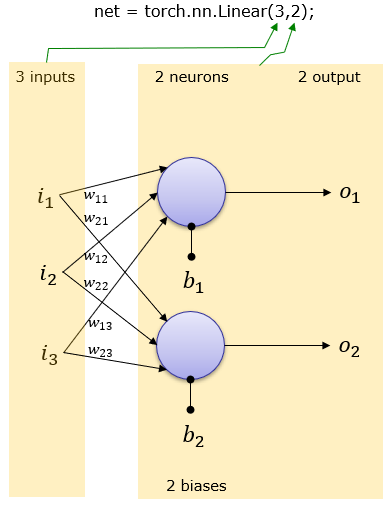



ReLU stands for rectified linear unit, and is a type of activation function. Mathematically, it is defined as y = max(0, x). Visually, it looks like the following:
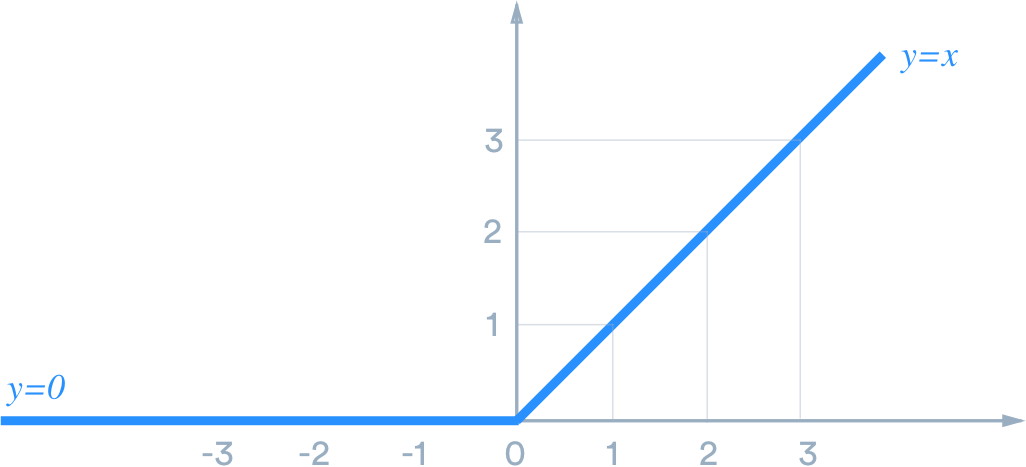

In [47]:
ln = nn.Linear(5, 10)
relu =nn.ReLU()

print(ln, type(ln))
random_x = torch.randn(5)
print(random_x)
y_ln = ln(random_x)
print(y_ln, type(y_ln), y_ln.shape)

y_relu = relu(y_ln)
print(y_relu, type(y_relu), y_relu.shape)


Linear(in_features=5, out_features=10, bias=True) <class 'torch.nn.modules.linear.Linear'>
tensor([ 3.2018, -0.0791,  0.7695,  0.0906, -1.8373])
tensor([ 1.8318,  2.4373,  1.6463,  0.2019,  0.0114,  1.1167,  1.3972,  0.5838,
        -0.3758,  0.5644], grad_fn=<AddBackward0>) <class 'torch.Tensor'> torch.Size([10])
tensor([1.8318, 2.4373, 1.6463, 0.2019, 0.0114, 1.1167, 1.3972, 0.5838, 0.0000,
        0.5644], grad_fn=<ReluBackward0>) <class 'torch.Tensor'> torch.Size([10])


## Prepare train data

In [48]:
from sklearn.datasets import load_boston

boston = load_boston()

# boston_dataset is a dictionary
# let's check what it contains
print(boston.keys())
#help(boston)


dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33  
506 50.0 5.0 22.532806324110698


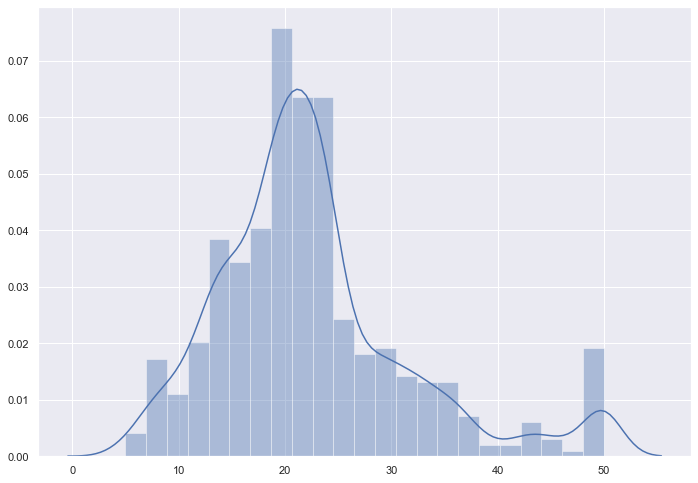

In [49]:

# feature_names -> ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
feature_names = boston.feature_names
boston_dataframe = pd.DataFrame(boston.data, columns=feature_names)
print(boston_dataframe.head())

X = boston.data
Y = boston.target

print(len(Y),max(Y),min(Y),sum(Y)/len(Y))
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(Y)
plt.show()

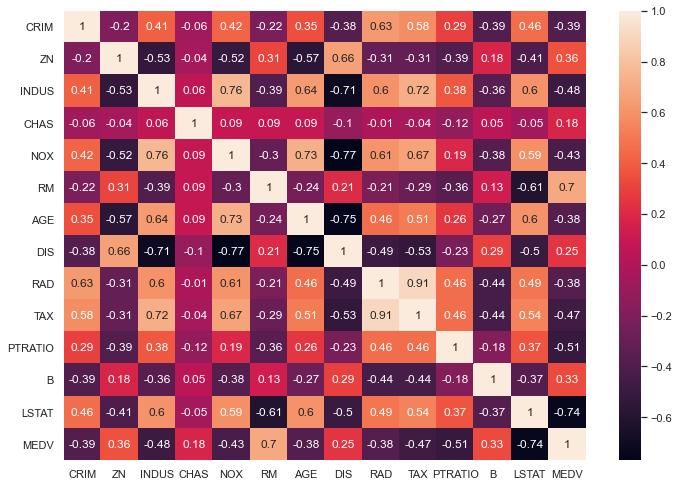

In [50]:
boston_dataframe['MEDV'] = boston.target
correlation_matrix = boston_dataframe.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

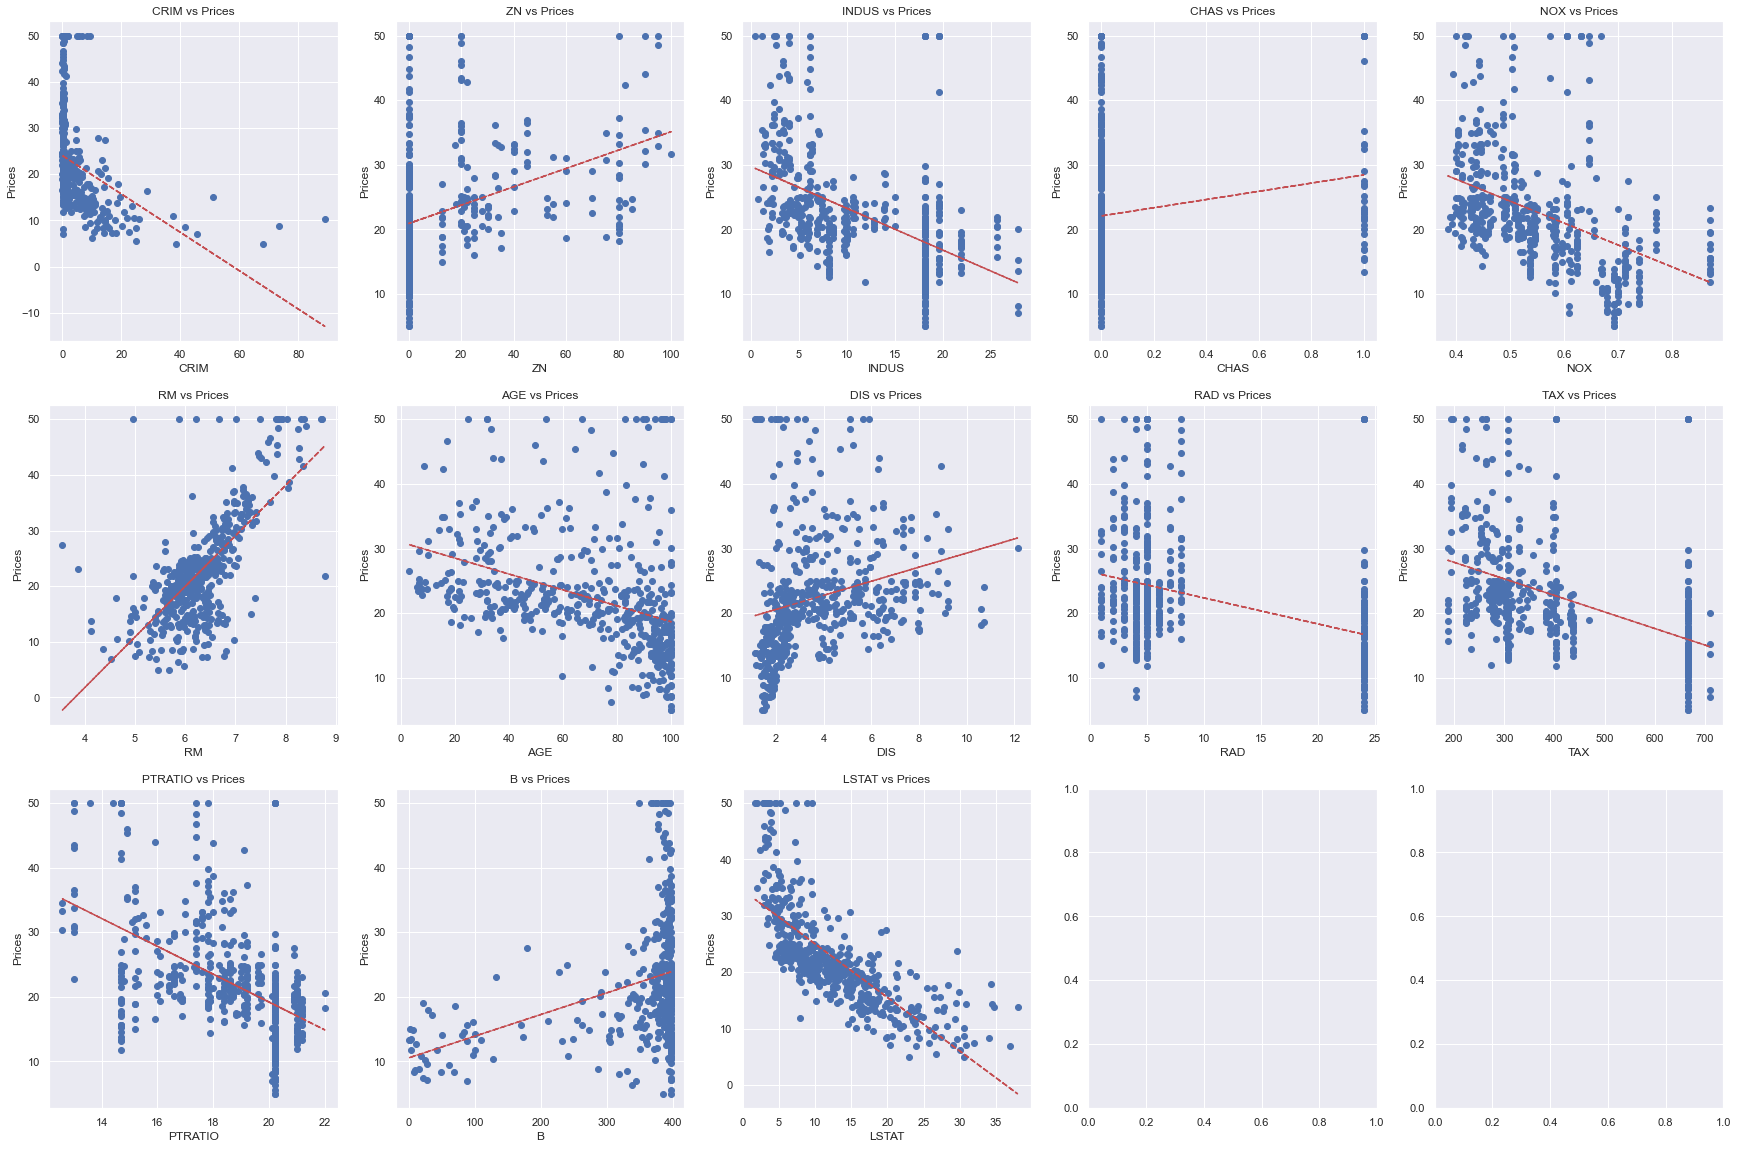

In [52]:
fig, axs = plt.subplots(nrows = 3, ncols=5, figsize=(30, 20))
for i, (ax, col) in enumerate(zip(axs.flat, feature_names)):
    x = X[:,i]
    pf = np.polyfit(x, Y, 1)
    p = np.poly1d(pf)

    ax.plot(x, Y, 'o')
    ax.plot(x, p(x),"r--")

    ax.set_title(col + ' vs Prices')
    ax.set_xlabel(col)
    ax.set_ylabel('Prices') 

https://www.journaldev.com/36576/pytorch-dataloader

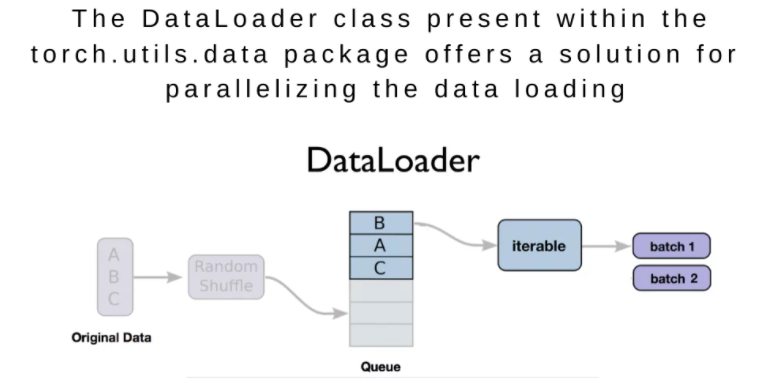



In [58]:
from sklearn.model_selection import train_test_split

# splits the training and test data set in 80% : 20%
# assign random_state to any value.This ensures consistency.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
Y_test = torch.tensor(Y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, Y_train)
#batch_size - Number of samples in each batch 
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)
print(len(train_iter))
help(train_iter)


(404, 13)
(102, 13)
(404,)
(102,)
41
Help on DataLoader in module torch.utils.data.dataloader object:

class DataLoader(typing.Generic)
 |  DataLoader(*args, **kwds)
 |  
 |  Data loader. Combines a dataset and a sampler, and provides an iterable over
 |  the given dataset.
 |  
 |  The :class:`~torch.utils.data.DataLoader` supports both map-style and
 |  iterable-style datasets with single- or multi-process loading, customizing
 |  loading order and optional automatic batching (collation) and memory pinning.
 |  
 |  See :py:mod:`torch.utils.data` documentation page for more details.
 |  
 |  Arguments:
 |      dataset (Dataset): dataset from which to load the data.
 |      batch_size (int, optional): how many samples per batch to load
 |          (default: ``1``).
 |      shuffle (bool, optional): set to ``True`` to have the data reshuffled
 |          at every epoch (default: ``False``).
 |      sampler (Sampler or Iterable, optional): defines the strategy to draw
 |          sample

## Define Model 
### Input : 13 variables, Output: house price, 3 hidden layers

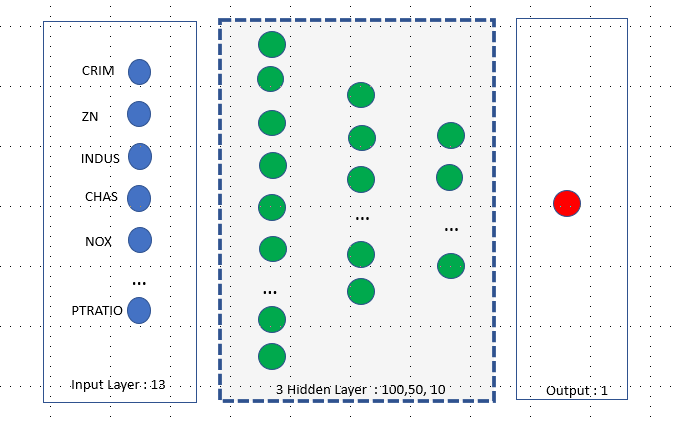

In [41]:
size_input = 13
size_hidden1 = 100
size_hidden2 = 50
size_hidden3 = 10
size_ouput =1

class BostonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(size_input, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(size_hidden3, size_ouput)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))


https://towardsdatascience.com/a-look-at-gradient-descent-and-rmsprop-optimizers-f77d483ef08b

The RMSprop optimizer is similar to the gradient descent algorithm with momentum. The RMSprop optimizer restricts the oscillations in the vertical direction. Therefore, we can increase our learning rate and our algorithm could take larger steps in the horizontal direction converging faster. The difference between RMSprop and gradient descent is on how the gradients are calculated. 

learning rate
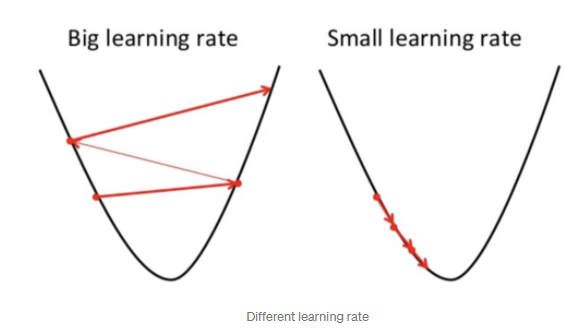

In [59]:
num_epochs = 400
learning_rate = 0.0001
model = BostonModel()

criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Train model

Epoch [1]/[400] running accumulative loss across all batches: 5705.045
Epoch [21]/[400] running accumulative loss across all batches: 2155.485
Epoch [41]/[400] running accumulative loss across all batches: 1932.261
Epoch [61]/[400] running accumulative loss across all batches: 1677.295
Epoch [81]/[400] running accumulative loss across all batches: 1438.248
Epoch [101]/[400] running accumulative loss across all batches: 1317.325
Epoch [121]/[400] running accumulative loss across all batches: 1153.628
Epoch [141]/[400] running accumulative loss across all batches: 1082.063
Epoch [161]/[400] running accumulative loss across all batches: 1055.866
Epoch [181]/[400] running accumulative loss across all batches: 954.824
Epoch [201]/[400] running accumulative loss across all batches: 921.703
Epoch [221]/[400] running accumulative loss across all batches: 862.083
Epoch [241]/[400] running accumulative loss across all batches: 825.646
Epoch [261]/[400] running accumulative loss across all batche

Text(0.5, 0, 'epoch')

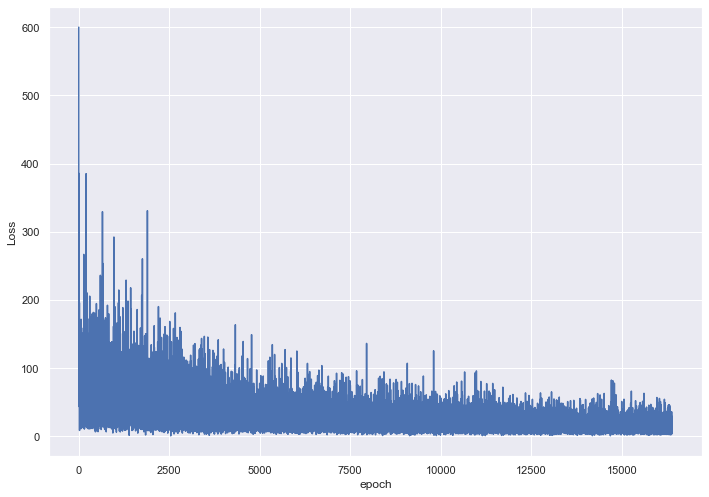

In [60]:
losses =[]
index = 0
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in train_iter:
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(inputs)

        # defining loss
        loss = criterion(outputs, labels)
        losses.append(loss)
        index +=1

        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()

        # updated weights based on computed gradients
        optimizer.step()
        
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
    running_loss = 0.0

print(index)  
plt.plot(range(index),losses)
plt.ylabel('Loss')
plt.xlabel('epoch')

## Verification

In [56]:
with torch.no_grad(): # we don't need gradients in the testing phase
    predicted = model(X_test)

print(X_test.shape)
print(Y_test.shape)
print(predicted.shape)

torch.Size([102, 13])
torch.Size([102, 1])
torch.Size([102, 1])


Text(0.5, 1.0, 'Predicted Price')

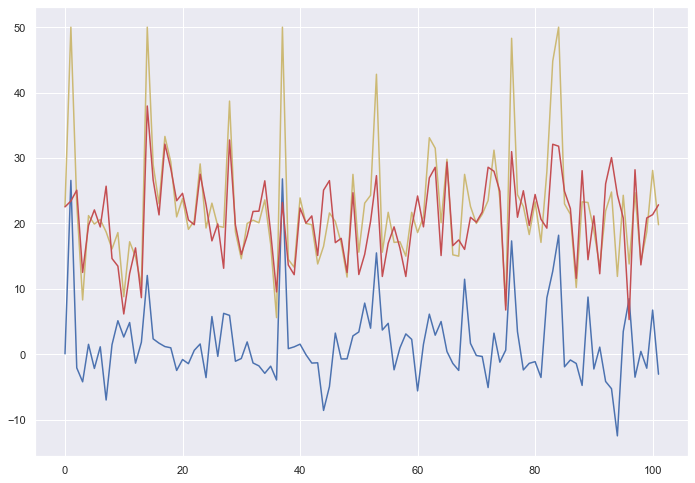

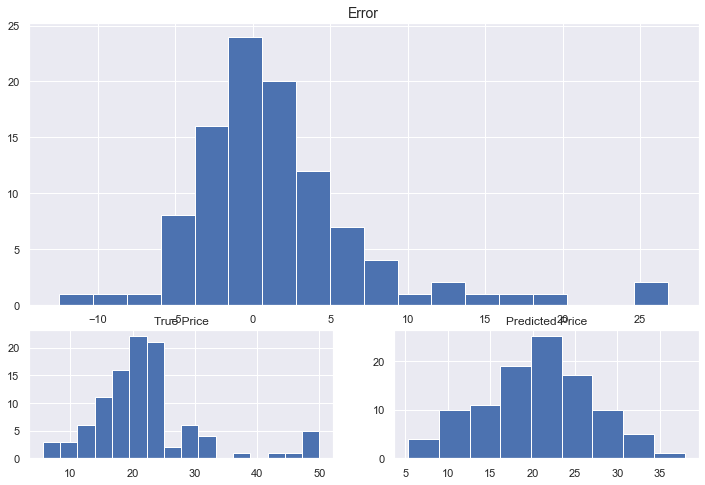

In [57]:
index = range(Y_test.numpy().shape[0])
plt.plot(index,Y_test.numpy()-predicted.numpy(),0)
plt.plot(index,Y_test.numpy(),'y')
plt.plot(index,predicted.numpy(),'r')

gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax3 = plt.subplot2grid(gridsize, (2, 1))


ax1.set_title('Error', fontsize=14)
ax1.hist(Y_test.numpy()-predicted.numpy(),bins ='auto')

ax2.hist(Y_test.numpy(), bins='auto')
ax2.set_title('True Price', fontsize=12)

ax3.hist(predicted.numpy(), bins='auto')
ax3.set_title('Predicted Price', fontsize=12)

